# Class 5 - Autoencoder demo

This notebook is based on  https://blog.keras.io/building-autoencoders-in-keras.html

We demonstrate auto-encoders using the MNIST-dataset.

## Loading packages and reading the data

# 1. Reading in the images and annotations

I start with defining the paths where the images and annotations can be found.

In [3]:
#from google.colab import drive
#drive.mount('/content/drive')

In [ ]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.preprocessing import OneHotEncoder
from sklearn import preprocessing

import matplotlib.image as mpimg
from skimage.io import imread, imshow
from skimage import data, color, io, filters, morphology,transform, exposure, feature, util
from scipy import ndimage

import keras
import tensorflow as tf
from tensorflow.python.keras.models import Model
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Activation
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.layers import Input, Dense, Dropout, Flatten, BatchNormalization
from tensorflow.python.keras.layers import Conv2D, MaxPooling2D, UpSampling2D
from keras.utils import np_utils
from tensorflow.keras.preprocessing import image
from tensorflow.python.keras import regularizers
from keras.callbacks import EarlyStopping

import cv2
import warnings
warnings.filterwarnings('ignore')

###### Voor Tensorflow-GPU ########

#config = tf.ConfigProto()
#config.gpu_options.per_process_gpu_memory_fraction = 0.9
#keras.backend.tensorflow_backend.set_session(tf.Session(config=config))

In [ ]:
train_path=  "/train.csv"
test_path = "/test.csv"

In [ ]:
#Reading in dataset
df_train = pd.read_csv(train_path)
df_test = pd.read_csv(test_path)

X_train = df_train.drop('label',axis=1).values
X_test  = df_test.drop('label',axis=1).values

X_train = X_train.astype('float32') / 255.
X_test = X_test.astype('float32') / 255.

In [ ]:
X_train.shape

(30000, 784)

# 1. Building autoencoder

To build an autoencoder, we no longer use the sequential model, but a functional model. In a functional model, you have the flexibility to state for each layer to which layers they connect.This means a model can have multiple inputs or outputs or different models that share layers. In the end, the model it self is build by specifying the input and the output layer. 

In [ ]:
from keras import layers
# Encoder 
    ## Placeholder for input
input_img = keras.Input(shape=(784,))

    ## Dense encoder layer 
encoded = layers.Dense(64, activation='relu')(input_img)

# Decoder
    ## Dense decoder layer
decoded = layers.Dense(784, activation='sigmoid')(encoded)

# Create autoencoder: start with input layer and end with decoded layer
autoencoder = keras.Model(input_img, decoded)


autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 784)]             0         
                                                                 
 dense (Dense)               (None, 64)                50240     
                                                                 
 dense_1 (Dense)             (None, 784)               50960     
                                                                 
Total params: 101,200
Trainable params: 101,200
Non-trainable params: 0
_________________________________________________________________


# 2. Compile and fit the model
Notice that both the input and output data is the same when fitting the model!.

In [ ]:
# Compile auto-encoder model
autoencoder.compile(optimizer='adam', loss='mean_squared_error')

# Fit model
epochs = 50
batchsize = 256
early_stopping =  EarlyStopping(patience=2)

autoencoder.fit(X_train, X_train,
                epochs=epochs,
                batch_size=batchsize,
                validation_split=0.2,
               callbacks= [early_stopping])

Epoch 1/50
94/94 [==============================] - 4s 8ms/step - loss: 0.0883 - val_loss: 0.0522
Epoch 2/50
94/94 [==============================] - 0s 5ms/step - loss: 0.0427 - val_loss: 0.0358
Epoch 3/50
94/94 [==============================] - 0s 5ms/step - loss: 0.0318 - val_loss: 0.0287
Epoch 4/50
94/94 [==============================] - 0s 5ms/step - loss: 0.0261 - val_loss: 0.0241
Epoch 5/50
94/94 [==============================] - 0s 5ms/step - loss: 0.0222 - val_loss: 0.0208
Epoch 6/50
94/94 [==============================] - 1s 6ms/step - loss: 0.0193 - val_loss: 0.0183
Epoch 7/50
94/94 [==============================] - 0s 5ms/step - loss: 0.0169 - val_loss: 0.0161
Epoch 8/50
94/94 [==============================] - 0s 5ms/step - loss: 0.0150 - val_loss: 0.0144
Epoch 9/50
94/94 [==============================] - 1s 6ms/step - loss: 0.0134 - val_loss: 0.0129
Epoch 10/50
94/94 [==============================] - 0s 5ms/step - loss: 0.0121 - val_loss: 0.0117
Epoch 11/50
94/94 [

# 3. Reconstruct the images

We predict the images:

In [ ]:
autoencoder_imgs = autoencoder.predict(X_test)

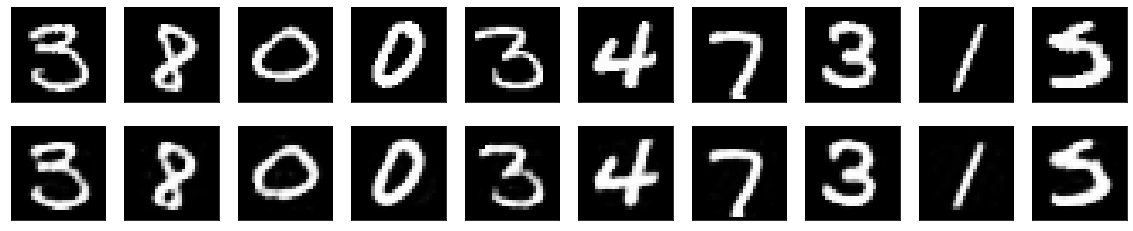

In [ ]:
n = 10 # aantal te tonen afbeeldingen
plt.figure(figsize=(20, 4))
for i in range(n):
    # Originelen
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(X_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Reconstructies
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(autoencoder_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

Ok, we can see that the images are reconstructed pretty well. But what has happened? Let's take a look at the encoder and decoder results seperately.
+ We create a seperate encoder model (starts with the input and ends at the encoder layer)

In [ ]:
encoder = Model(input_img, encoded)

+ We also create a seperate decoder model. (it starts with an input with the dimensions of the last encoder layer and ends with the decoder layer).

In [ ]:
encoded_input = Input(shape=(64,))
# Haal de laatste layer van het autoencoder model op
decoder_layer = autoencoder.layers[-1]
# creëer het model
decoder = Model(encoded_input, decoder_layer(encoded_input))

Now, we first use the encoder to predict the output of the encoder and then use this as input in the decoder.

In [ ]:
# predictie op de test images
encoded_imgs = encoder.predict(X_test)
decoded_imgs = decoder.predict(encoded_imgs)

In [ ]:
decoded_imgs.shape
decoded_imgs.shape

(12000, 784)

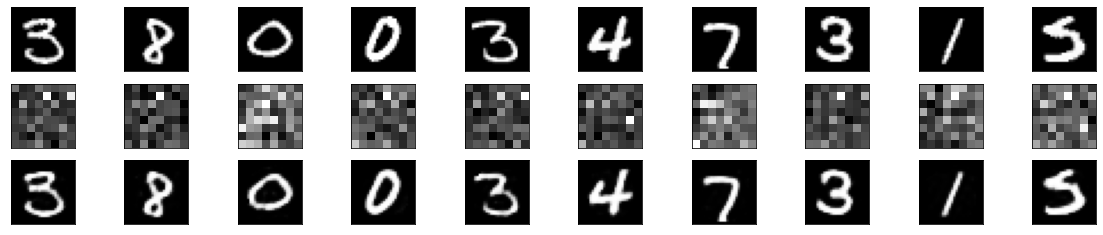

In [ ]:
n = 10 # aantal te tonen afbeeldingen
plt.figure(figsize=(20, 4))
for i in range(n):
    # Originals
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(X_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    # Encoded
    ax = plt.subplot(3, n, i + 1+n)
    plt.imshow(encoded_imgs[i].reshape(8, 8))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Decoded reconstructions
    ax = plt.subplot(3, n, i + 1 + 2*n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

So, we can see that the images are first deconstructed to something very vague, but the model is able to reconstruct the images again from that. But, why would we want to do this? A first application is anomaly detection.

# 4. Anomaly detection
## 4.1 the mnist dataset
Say, we get an image from the fashion mmnist-dataset. And we try to use our previous model to reconstruct this image. Will this work? Let's see...

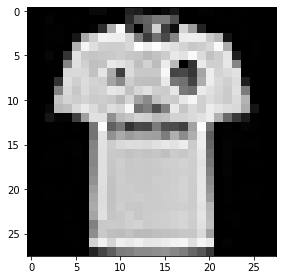

In [ ]:
# Using this auto-encoder to reconstruct the fashion-mnist
mnist = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/fashion-mnist_test.csv')
mnist = mnist.drop('label',axis=1).values/255
imshow(mnist[0].reshape(28, 28))

In [ ]:
encoded_imgs_mnist = encoder.predict(mnist)
decoded_imgs_mnist = decoder.predict(encoded_imgs_mnist)
autoencoder_imgs_mnist = autoencoder.predict(mnist)

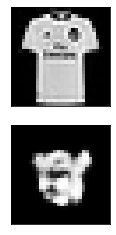

In [ ]:
n = 1 # aantal te tonen afbeeldingen
plt.figure(figsize=(20, 4))
for i in range(n):
    # Originelen
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(mnist[0].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Reconstructies
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(autoencoder_imgs_mnist[0].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

We can see this doesn't work very well. This is because the model is trained on numbers, not on clothes. You could say that the picture of the t-shirt is an anomaly: it deviates from our training dataset. So, we can use auto-encoders to do anomaly detection: if our model is not able to reconstruct the input in a satisfying way, the input can be considered as an anomaly. But how do you decide if the reconstruction is good or bad? We use the mse

In [ ]:
from sklearn.metrics import mean_squared_error 
mean_squared_error(X_test,autoencoder_imgs)

0.0043109404

The overal mse of the test set of the mnist dataset is 0.004. Now, let's see what the error is of our image from the fashion mnist is.

In [ ]:
mean_squared_error(mnist[0],autoencoder_imgs_mnist[0])

0.16961426813583386

We see this is a lot higher. So to do anomaly detection, we will set a limit for the error. If the error is higher than this limit, a sample will be considered as an anomaly. We will try this on a credit card dataset.

## 4.2 credit card fraud  detection
We will use a dataset with credit card transactions over a 2-day period.  The data has been transformed using PCA transformation(s) due to privacy reasons. The two features that haven’t been changed are Time and Amount. Time contains the seconds elapsed between each transaction and the first transaction in the dataset.

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/creditcard.csv")

###4.2.1 Data exploration

In [ ]:
df.shape

(284807, 31)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

There is no missing data. We see there is a feature 'class'. This indicates if the transaction is fraudulent (1) or not (0).

In [ ]:
df['Class'].value_counts()

0    284315
1       492
Name: Class, dtype: int64

In [ ]:
df['Class'] = df['Class'].astype('category')

###4.2.2 Standardizing

In [ ]:
from sklearn.preprocessing import StandardScaler
num_feat = df.select_dtypes(include=['int64', 'float64']).columns
df[num_feat] = StandardScaler().fit_transform(df[num_feat])

#4.2.3 Train/test split
There are 284 315 non-fraudulent transactions and 492 fraudulent transactions. Any of the algorithms we have seen before would have a hard time dealing with this kind of unbalance. We can train an auto-encoder on the non-fraudulent data (and no fraudulent cases!). Then, we can detect the fraudulent cases in the test-set.

In [ ]:
# Split train and test data
X_train, X_test = train_test_split(df, test_size=0.2, random_state=123)

# Remove fraudulent cases from the training set and then drop the label. We do not need the label
# because we are doing unsupervised learning

X_train = X_train[X_train.Class == 0]
X_train = X_train.drop(['Class'], axis=1)

# Split the test set in features and labels. We will only use the label to evaluate our model at the end
y_test = X_test['Class']
X_test = X_test.drop(['Class'], axis=1)

# Split the test set in a validation set and a test-set (We will need a validation set to determine the cut-off)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.4, random_state=123)


# Put data in rigth format
X_train = X_train.values
X_val = X_val.values
X_test = X_test.values

X_train.shape

(227468, 30)

In [ ]:
y_val.value_counts()

0    34111
1       66
Name: Class, dtype: int64

In [ ]:
y_test.value_counts()

0    22736
1       49
Name: Class, dtype: int64

###4.2.4 Building the autoencoder model

In [ ]:
#The number of features is the input shape
input_dim = X_train.shape[1]     ##30

#encoder model
 ##input layer
input_layer = Input(shape=(input_dim, ))

 ##encoder layers
encoder = Dense(14, activation="tanh", activity_regularizer=regularizers.l1(10e-5))(input_layer)
encoder = Dense(7, activation="relu")(encoder)

#decoder model
decoder = Dense(14, activation="tanh")(encoder)
decoder = Dense(input_dim, activation="relu")(decoder)

#build autoencoder model
autoencoder = Model(inputs=input_layer, outputs=decoder)

###4.2.5 Compiling and fitting the model

In [ ]:
nb_epoch = 100
batch_size = 32

autoencoder.compile(optimizer='adam', 
                    loss='mean_squared_error', 
                    metrics=['accuracy'])

early_stopping =  EarlyStopping(patience=10,  restore_best_weights=True)


history = autoencoder.fit(X_train, X_train,
                    epochs=nb_epoch,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_split=0.2,
                    verbose=1,
                    callbacks=[early_stopping])

Epoch 1/100
5687/5687 [==============================] - 42s 7ms/step - loss: 0.7857 - accuracy: 0.4080 - val_loss: 0.6990 - val_accuracy: 0.4920
Epoch 2/100
5687/5687 [==============================] - 36s 6ms/step - loss: 0.7199 - accuracy: 0.5032 - val_loss: 0.6819 - val_accuracy: 0.5147
Epoch 3/100
5687/5687 [==============================] - 35s 6ms/step - loss: 0.7071 - accuracy: 0.5229 - val_loss: 0.6719 - val_accuracy: 0.5322
Epoch 4/100
5687/5687 [==============================] - 35s 6ms/step - loss: 0.6991 - accuracy: 0.5402 - val_loss: 0.6669 - val_accuracy: 0.5464
Epoch 5/100
5687/5687 [==============================] - 38s 7ms/step - loss: 0.6933 - accuracy: 0.5436 - val_loss: 0.6606 - val_accuracy: 0.5464
Epoch 6/100
5687/5687 [==============================] - 38s 7ms/step - loss: 0.6884 - accuracy: 0.5465 - val_loss: 0.6564 - val_accuracy: 0.5493
Epoch 7/100
5687/5687 [==============================] - 32s 6ms/step - loss: 0.6848 - accuracy: 0.5477 - val_loss: 0.6561 -

###4.2.6 Predicting/reconstructing credit card transactions

In [ ]:
predictions_train = autoencoder.predict(X_train)
predictions_val = autoencoder.predict(X_val)
predictions_test = autoencoder.predict(X_test)

###4.2.7 Taking a look at the MSE

In [ ]:
mse_test = mean_squared_error(X_test,predictions_test)
mse_val = mean_squared_error(X_val,predictions_val)
mse_train = mean_squared_error(X_train,predictions_train)
print(mse_train)
print(mse_val)
print(mse_test)

0.6514403689852685
0.6684423923411903
0.6881585595288959


Not a lot of difference, but that is not surprising, since in all three datasets most samples are non-frauduelent. Now, how do we detect the fraudulent cases? We calculate the error of each sample individually and select those that have an error higher than our limit. But, how do you set this limit? 
+ You could choose e.g the 5% highest errors. But we already know we have less than 5% fraudulent cases. So, the limit is a bit dependent on the context information or the number of anomalies you are expecting. 
+ We now only around 0.1 % of transactions are fraudulent, so I start with this limit.

In [ ]:
# Calculate errors in training set
error_train = np.mean(np.power(X_train - predictions_train, 2), axis=1) 
limit = np.percentile(error_train, 99.9)
print(limit)

27.48145180197953


In [ ]:
# Calculate error in validation set and compare to limit
error_val = np.mean(np.power(X_val - predictions_val, 2), axis=1)
fraud = error_val > limit
fraud.sum()

41

Our limit seems to be a bit to hars, but let's first dive deeper into the results.

In [ ]:
error_val_pd = pd.DataFrame(error_val)
error_val_pd.columns = ['error']
error_val_pd['id'] = range(len(error_val_pd))
error_val_pd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34177 entries, 0 to 34176
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   error   34177 non-null  float64
 1   id      34177 non-null  int64  
dtypes: float64(1), int64(1)
memory usage: 534.1 KB


In [ ]:
from sklearn.metrics import confusion_matrix, precision_recall_curve

confusion_mat = confusion_matrix(y_val, fraud)
print(confusion_mat)

[[34084    27]
 [   52    14]]


In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_val, fraud))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     34111
           1       0.34      0.21      0.26        66

    accuracy                           1.00     34177
   macro avg       0.67      0.61      0.63     34177
weighted avg       1.00      1.00      1.00     34177



Of the true fraud cases, we only found 21%. We take a look at the (labeled) errors.

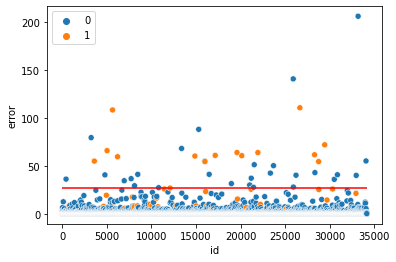

In [ ]:
import seaborn as sns
sns.scatterplot(x=error_val_pd.id, y=error_val_pd.error, hue = np.array(y_val))
plt.hlines(limit, 0, len(error_val), colors='r')

Increasing the limit will lower the false positives (transactions that are mistakenly seen as frauduleus), but will also lower the true positives. Lowering the limit will do just the opposite. We need to find a balance between this.

In [ ]:
limit = np.percentile(error_train, 97.5)
fraud2 = error_val > limit
fraud2.sum()

confusion_mat = confusion_matrix(y_val, fraud2)
print(confusion_mat)

print(classification_report(y_val, fraud2))

[[33289   822]
 [   11    55]]
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     34111
           1       0.06      0.83      0.12        66

    accuracy                           0.98     34177
   macro avg       0.53      0.90      0.55     34177
weighted avg       1.00      0.98      0.99     34177



This is a lot better. 55 of the 66 fraudulent cases are caught. However, there are also a lot of non-fraudulent cases that are classified as fraudulent (836). If you would work at a bank, you would have to consider which is worse: calling a lot of clients checking if there is something wrong while it was unnecesary or missing fraudulent cases? It really is a decision that is context-based (and subjective).

We test our final model on the test set to get a reliable evaluation.

In [ ]:
error_test = np.mean(np.power(X_test - predictions_test, 2), axis=1)
fraud_test = error_test > limit

confusion_mat = confusion_matrix(y_test, fraud_test)
print(confusion_mat)

print(classification_report(y_test, fraud_test))

[[22181   555]
 [    7    42]]
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     22736
           1       0.07      0.86      0.13        49

    accuracy                           0.98     22785
   macro avg       0.54      0.92      0.56     22785
weighted avg       1.00      0.98      0.99     22785



#5 Denoising autoencoder
Have you ever taken a picture that you loved, but the quality is just too low to be usable? Well, auto-encoders could solve your problem. You take a bunch of pictures that are of high quality, but you will purposely decrease the quality. Use the decreased quality images as input for the auto-encoder and the high-quality images as the output. Fit you model and you now have a model that can enhance images. We will try this in the mnist dataset.

In [ ]:
# We will not use the full dataset, to avoid very long training times
trainingsize = 1000 
testsize = 10    

df_train = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/mnist_data/train.csv')
df_test = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/mnist_data/test.csv')

X_train = df_train.drop('label',axis=1).values
X_test  = df_test.drop('label',axis=1).values

X_train = X_train.astype('float32') / 255.
X_test = X_test.astype('float32') / 255.


X_train = X_train[:trainingsize]
X_test = X_test[:testsize]

X_train = X_train.reshape((len(X_train),28, 28,1))
X_test = X_test.reshape((len(X_test),28, 28,1))

In [ ]:
def pixalate_image(image, scale_percent = 30):
    width = int(image.shape[1] * scale_percent / 100)
    height = int(image.shape[0] * scale_percent / 100)
    dim = (width, height)

    small_image = cv2.resize(image, dim, interpolation = cv2.INTER_AREA)
  
    # scale back to original size
    dim = (image.shape[1], image.shape[0])

    low_res_image = cv2.resize(small_image, dim, interpolation = cv2.INTER_AREA)

    return low_res_image

In [ ]:
# get low resolution images for the training set
train_x_px = []

for i in range(X_train.shape[0]):
    temp = pixalate_image(X_train[i][:,:,:])
    train_x_px.append(temp)

train_x_px = np.array(train_x_px)
train_x_px = train_x_px.reshape((len(train_x_px),28, 28,1))

# get low resolution images for the test set
test_x_px = []

for i in range(X_test.shape[0]):
    temp = pixalate_image(X_test[i][:,:,:])
    test_x_px.append(temp)

test_x_px = np.array(test_x_px)
test_x_px = test_x_px.reshape((len(test_x_px),28, 28,1))

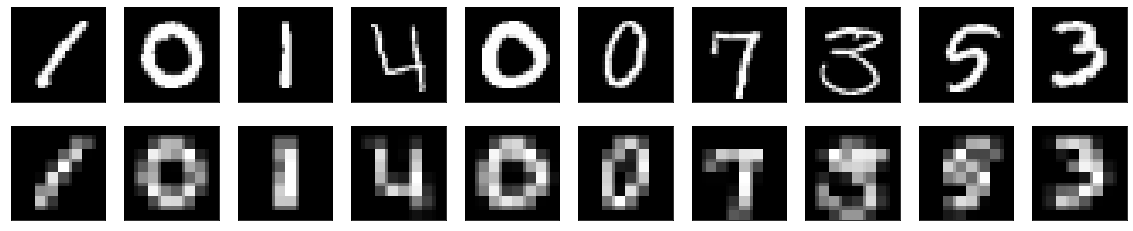

In [ ]:
n = 10 # aantal te tonen afbeeldingen
plt.figure(figsize=(20, 4))
for i in range(n):
    # Originals
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(X_train[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Decoded reconstructions
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(train_x_px[i].reshape(28,28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [ ]:
# Building model
Input_img = Input(shape=(28, 28,1))  
    
#encoding architecture
x1 = Conv2D(256, (3, 3), activation='relu', padding='same')(Input_img)
x2 = Conv2D(128, (3, 3), activation='relu', padding='same')(x1)
x2 = MaxPooling2D( (2, 2))(x2)
encoded = Conv2D(64, (3, 3), activation='relu', padding='same')(x2)

# decoding architecture
x3 = Conv2D(64, (3, 3), activation='relu', padding='same')(encoded)
x3 = UpSampling2D((2, 2))(x3)
x2 = Conv2D(128, (3, 3), activation='relu', padding='same')(x3)
x1 = Conv2D(256, (3, 3), activation='relu', padding='same')(x2)
decoded = Conv2D(1, (3, 3), padding='same')(x1)

autoencoder = Model(Input_img, decoded)

In [ ]:
autoencoder.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Total params: 0
Trainable params: 0
Non-trainable params: 0
_________________________________________________________________


In [ ]:
autoencoder.compile(optimizer='adam', loss='mse')

early_stopping =  EarlyStopping(patience=10,  restore_best_weights=True)


a_e = autoencoder.fit(train_x_px, X_train,
            epochs=50,
            batch_size=256,
            validation_split=0.2,
            callbacks=[early_stopping])

Epoch 1/50
4/4 [==============================] - 10s 538ms/step - loss: 0.1148 - val_loss: 0.1208
Epoch 2/50
4/4 [==============================] - 0s 102ms/step - loss: 0.1148 - val_loss: 0.1208
Epoch 3/50
4/4 [==============================] - 0s 102ms/step - loss: 0.1148 - val_loss: 0.1208
Epoch 4/50
4/4 [==============================] - 0s 104ms/step - loss: 0.1148 - val_loss: 0.1208
Epoch 5/50
4/4 [==============================] - 0s 103ms/step - loss: 0.1148 - val_loss: 0.1208
Epoch 6/50
4/4 [==============================] - 0s 122ms/step - loss: 0.1148 - val_loss: 0.1208
Epoch 7/50
4/4 [==============================] - 0s 99ms/step - loss: 0.1148 - val_loss: 0.1208
Epoch 8/50
4/4 [==============================] - 0s 100ms/step - loss: 0.1148 - val_loss: 0.1208
Epoch 9/50
4/4 [==============================] - 0s 121ms/step - loss: 0.1148 - val_loss: 0.1208
Epoch 10/50
4/4 [==============================] - 0s 100ms/step - loss: 0.1148 - val_loss: 0.1208
Epoch 11/50
4/4 [==

In [ ]:
y_restored = autoencoder.predict(test_x_px)

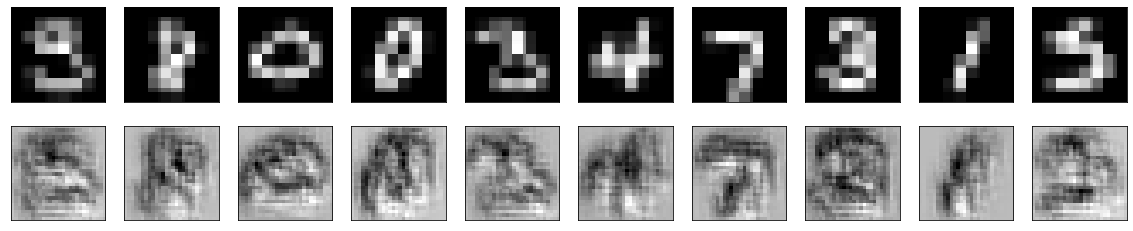

In [ ]:
n = 10 # aantal te tonen afbeeldingen
plt.figure(figsize=(20, 4))
for i in range(n):
    # Originals
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(test_x_px[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Decoded reconstructions
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(y_restored[i].reshape(28,28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()